In [434]:
import shap
import torch
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
import pandas as pd
import sys
sys.path.append("../../../")
import D3QN

device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
# Enable the plots in jupyter
shap.initjs()

def parse(func,size=100):
    X = []
    feature_names = list(func().keys())
    print(feature_names)
    for _ in range(size):
        x = func()
        X.append(list(x.values()))
        #print(x, y)
    return X,feature_names

def load_data(filepath,count=None):
    X,Y = [],[]
    df = pd.read_csv(filepath)
    for i in range(len(df)):
        obs = df.iloc[i, 0:-1].to_dict()
        label = df.iloc[i, -1]
        X.append(list(obs.values()))
        Y.append(label)
        feature_names = list(obs.keys())
    print(feature_names)
    if count is None:
        count = len(X)
    #随机打乱
    index = [i for i in range(len(X))]
    random.shuffle(index)
    X = np.array(X)[index]
    Y = np.array(Y)[index]
    return X[:count],Y[:count],feature_names

In [435]:

class DuelingDeepQNetwork(nn.Module):
    def __init__(self, alpha, state_dim, action_dim, fc1_dim, fc2_dim):
        super(DuelingDeepQNetwork, self).__init__()

        self.fc1 = nn.Linear(state_dim, fc1_dim)
        self.fc2 = nn.Linear(fc1_dim, fc2_dim)
        self.V = nn.Linear(fc2_dim, 1)
        self.A = nn.Linear(fc2_dim, action_dim)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.to(device)

    def forward(self, state):
        x = T.relu(self.fc1(state))
        x = T.relu(self.fc2(x))

        V = self.V(x)
        A = self.A(x)
        Q = V + A - T.mean(A, dim=-1, keepdim=True)

        return Q

    def save(self, file_path):
        T.save(self, file_path)


## cache agent

In [436]:
class CacheAgentDataset():
    def gen(self):
        L1_size = random.choice([4,8, 16, 32])
        L2_size = random.choice([128,256,512])
        L3_size = random.choice([500,600,700,1000])
        servie_size=random.uniform(0.05, 10)

        free_storage_size_ratio_L1 = random.uniform(0, 1)
        free_storage_size_ratio_L2 = random.uniform(0, 1)
        free_storage_size_ratio_L3 = random.uniform(0, 1)

        obs = {
            "es_load":random.uniform(0, 1),
            "free_storage_size_ratio_L1":random.uniform(0, 1),
            "free_storage_size_ratio_L2":random.uniform(0, 1),
            "free_storage_size_ratio_L3":random.uniform(0, 1),
            "can_L1_fit":free_storage_size_ratio_L1*servie_size<=L1_size,
            "can_L2_fit":free_storage_size_ratio_L2*servie_size<=L2_size,
            "can_L3_fit":free_storage_size_ratio_L3*servie_size<=L3_size,
            "servie_size":random.uniform(50, 1000),
            "estimated_fetch_time":random.uniform(1, 60),
            "is_popular":0,
            "charm":1,
            "service_request_frequency":0,
            "nearby_servers_count":0,
            "cached_in_nearby_servers":0,
            "es_request_frequency":0
        }
        return obs

## L1

In [437]:
SAMPLE_SIZE = 200

'../../stages/final_2/cache_agent/3/D3QN_q_eval.pth'
model = torch.load('../../stages/final_2/cache_agent/5/D3QN_q_eval.pth')
torch.set_grad_enabled(True)
func = CacheAgentDataset().gen
#X,feature_names = parse(func)
X,Y,feature_names = load_data("./cache.csv", SAMPLE_SIZE)
#print(X,Y)

data = torch.tensor(X).float()
e = shap.DeepExplainer(model, data)
shap_values = e.shap_values(data)
expected_value = list(e.expected_value)
data = data.numpy()

['es_load', 'free_storage_size_ratio_L1', 'free_storage_size_ratio_L2', 'free_storage_size_ratio_L3', 'can_L1_fit', 'can_L2_fit', 'can_L3_fit', 'service_size', 'estimated_fetch_time', 'is_popular', 'charm', 'service_request_frequency', 'nearby_servers_count', 'cached_in_nearby_servers', 'es_request_frequency']


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


KeyboardInterrupt: 

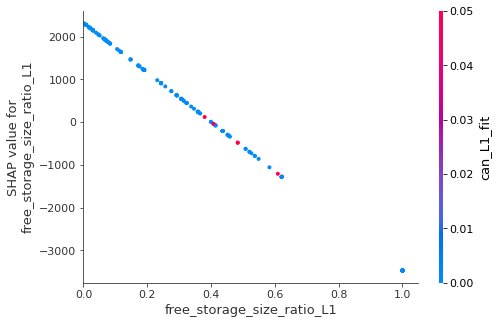

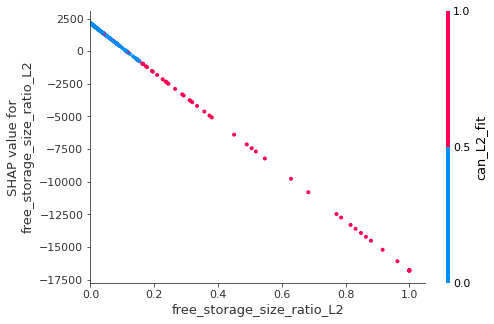

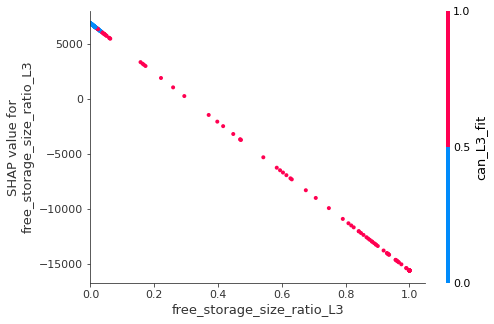

In [ ]:

# add fluction to shape values
#for i in range(len(shap_values[action_index])):
#    shap_values[action_index][i] += random.uniform(-100, 100)

shap.dependence_plot(
    ind="free_storage_size_ratio_L1",
    shap_values=shap_values[1],
    features=data,
    feature_names=feature_names,
    interaction_index="can_L1_fit",
    xmin=0, xmax=1
)

shap.dependence_plot(
    ind="free_storage_size_ratio_L2",
    shap_values=shap_values[2],
    features=data,
    feature_names=feature_names,
    interaction_index="can_L2_fit",
    xmin=0, xmax=1
)

shap.dependence_plot(
    ind="free_storage_size_ratio_L3",
    shap_values=shap_values[3],
    features=data,
    feature_names=feature_names,
    interaction_index="can_L3_fit",
    xmin=0, xmax=1
)

## 👆上面的已作废

In [ ]:
import shap
import sklearn.neural_network
import matplotlib.pyplot as plt

X,Y,feature_names = load_data("./cache.csv")
actions = ["IDLE","L1","L2","L3"]
t = []
for i in Y:
    t.append(actions.index(i))
model = sklearn.neural_network.MLPClassifier(max_iter=1000).fit(X,t)


['es_load', 'free_storage_size_ratio_L1', 'free_storage_size_ratio_L2', 'free_storage_size_ratio_L3', 'can_L1_fit', 'can_L2_fit', 'can_L3_fit', 'service_size', 'estimated_fetch_time', 'is_popular', 'charm', 'service_request_frequency', 'nearby_servers_count', 'cached_in_nearby_servers', 'es_request_frequency']


In [ ]:
SAMPLE_SIZE = 1000

#打乱数组
def shuffle(X):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    return X

data = shuffle(X)[:SAMPLE_SIZE]

explainer = shap.Explainer(lambda x: model.predict_proba(x), data)
shap_values = explainer(data).values

print(shap_values.shape)


Permutation explainer: 1001it [01:00, 13.53it/s]                         

(1000, 15, 4)


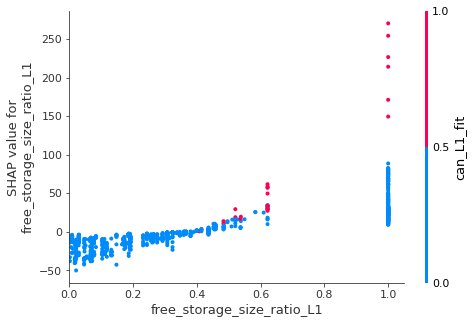

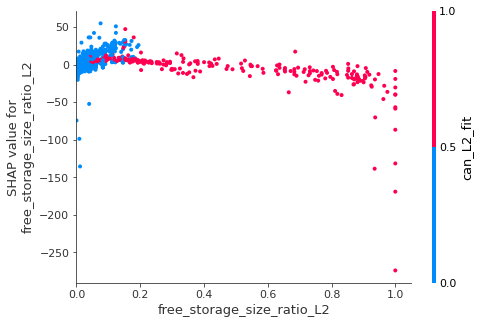

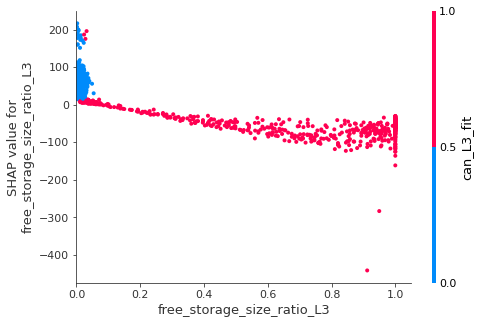

In [ ]:
cache_level = 1
shap.dependence_plot(
    ind="free_storage_size_ratio_L1",
    shap_values=shap_values[:,:,cache_level]*5000,
    features=data,
    feature_names=feature_names,
    interaction_index="can_L1_fit",
    xmin=0, xmax=1,
    show=False
)
plt.savefig(f'./screenshot/L{cache_level}_1.png',dpi = 150,bbox_inches = 'tight')

shap.dependence_plot(
    ind=f"free_storage_size_ratio_L2",
    shap_values=shap_values[:,:,cache_level]*5000,
    features=data,
    feature_names=feature_names,
    interaction_index=f"can_L2_fit",
    xmin=0, xmax=1,
    show=False
)
plt.savefig(f'./screenshot/L{cache_level}_2.png',dpi = 150,bbox_inches = 'tight')


shap.dependence_plot(
    ind=f"free_storage_size_ratio_L3",
    shap_values=shap_values[:,:,cache_level]*5000,
    features=data,
    feature_names=feature_names,
    interaction_index=f"can_L3_fit",
    xmin=0, xmax=1,
    show=False
)
plt.savefig(f'./screenshot/L{cache_level}_3.png',dpi = 150,bbox_inches = 'tight')


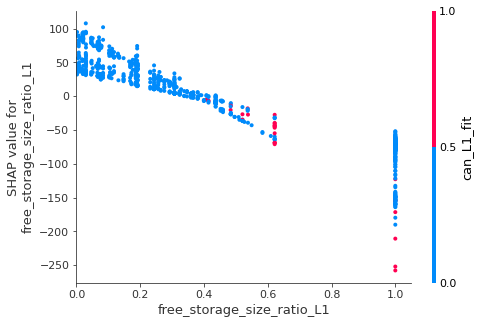

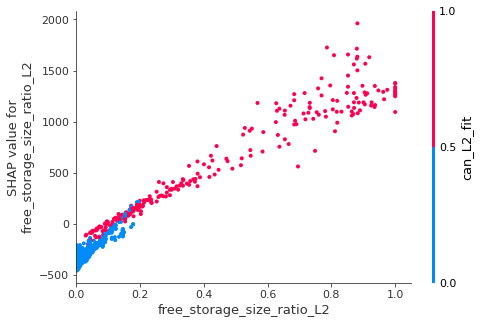

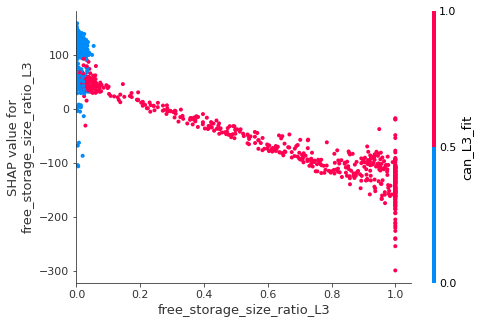

In [ ]:
cache_level = 2
shap.dependence_plot(
    ind="free_storage_size_ratio_L1",
    shap_values=shap_values[:,:,cache_level]*5000,
    features=data,
    feature_names=feature_names,
    interaction_index="can_L1_fit",
    xmin=0, xmax=1,
    show=False
)
plt.savefig(f'./screenshot/L{cache_level}_1.png',dpi = 150,bbox_inches = 'tight')

shap.dependence_plot(
    ind=f"free_storage_size_ratio_L2",
    shap_values=shap_values[:,:,cache_level]*5000,
    features=data,
    feature_names=feature_names,
    interaction_index=f"can_L2_fit",
    xmin=0, xmax=1,
    show=False
)
plt.savefig(f'./screenshot/L{cache_level}_2.png',dpi = 150,bbox_inches = 'tight')


shap.dependence_plot(
    ind=f"free_storage_size_ratio_L3",
    shap_values=shap_values[:,:,cache_level]*5000,
    features=data,
    feature_names=feature_names,
    interaction_index=f"can_L3_fit",
    xmin=0, xmax=1,
    show=False
)
plt.savefig(f'./screenshot/L{cache_level}_3.png',dpi = 150,bbox_inches = 'tight')

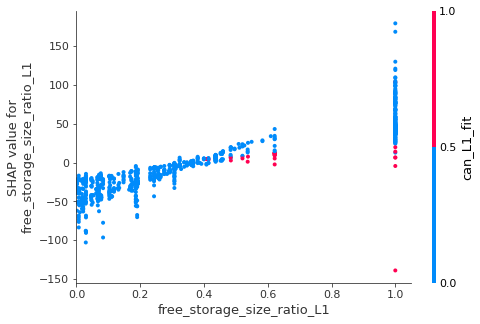

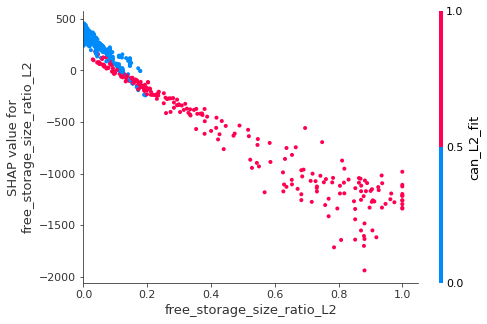

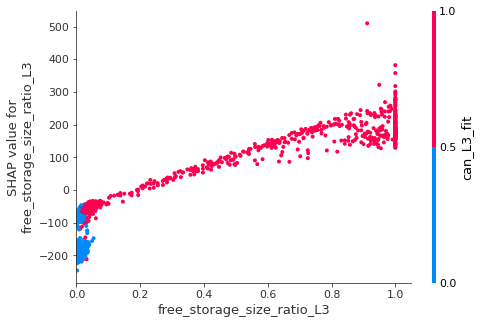

In [ ]:
cache_level = 3
shap.dependence_plot(
    ind="free_storage_size_ratio_L1",
    shap_values=shap_values[:,:,cache_level]*5000,
    features=data,
    feature_names=feature_names,
    interaction_index="can_L1_fit",
    xmin=0, xmax=1,
    show=False
)
plt.savefig(f'./screenshot/L{cache_level}_1.png',dpi = 150,bbox_inches = 'tight')

shap.dependence_plot(
    ind=f"free_storage_size_ratio_L2",
    shap_values=shap_values[:,:,cache_level]*5000,
    features=data,
    feature_names=feature_names,
    interaction_index=f"can_L2_fit",
    xmin=0, xmax=1,
    show=False
)
plt.savefig(f'./screenshot/L{cache_level}_2.png',dpi = 150,bbox_inches = 'tight')


shap.dependence_plot(
    ind=f"free_storage_size_ratio_L3",
    shap_values=shap_values[:,:,cache_level]*5000,
    features=data,
    feature_names=feature_names,
    interaction_index=f"can_L3_fit",
    xmin=0, xmax=1,
    show=False
)
plt.savefig(f'./screenshot/L{cache_level}_3.png',dpi = 150,bbox_inches = 'tight')